# Tutorial on ebcpy

Assume the following situation.
From an experiment we have gathered following data:
<img src="data/measured_data.png">
We want to use the data as an input to a simulation. However, as visible, the data is noisy and thus may lead to instability of our simulation.

First we will load modules supporting this tutorial. Note that you should install matplotlib first if not already happenend, as only this tutorial needs matplotlib. For usage of ebcpy, you don't need it.

In [2]:
import os
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

C:\Users\sbl\AppData\Local\Temp\ipykernel_7904\967215733.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  from pandas.plotting import register_matplotlib_converters


# Data Types
Let's specify the path to our measurement data and load it.  

Variables            measured_T
Tags                        raw
Time                           
2019-12-21 14:10:03  293.764306
2019-12-21 14:10:04  294.581815
2019-12-21 14:10:05  294.757593
2019-12-21 14:10:06  294.236406
2019-12-21 14:10:07  294.995937
...                         ...
2019-12-21 15:10:00  305.029739
2019-12-21 15:10:01  306.215838
2019-12-21 15:10:02  305.805173
2019-12-21 15:10:03  306.255180
2019-12-21 15:10:03  305.630872

[3610 rows x 1 columns]


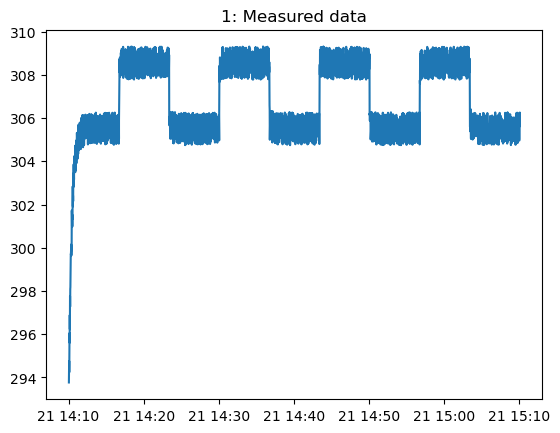

In [4]:
from ebcpy import data_types
# Specify the path to the measured data:
path = os.path.join(os.getcwd(), "data", "measuredData.csv")
tsd = data_types.TimeSeriesData(path, key="test")
print(tsd)
plt.plot(tsd["measured_T"])
plt.title("1: Measured data")
plt.show()

If you're familiar with `python` and `DataFrames`, you will ask  yourself: **Why do I need the TimeSeriesData-Class?** We implemented this class to combine the powerful `pandas.DataFrame` class with new functions for an easy usage in the context of Building Energy Systems for three main reasons:
- Most data in our case is Time-Dependent, therefore functions for easy conversion between seconds (for simulation) and Timestamps (for measurements) is needed
- Most data is stored in files. Typically .hdf and .mat is used, .csv and even .xlsx files occur frequently. Pandas offers different functions (`from_hdf`, `from_csv`) but no function for loading Modelica-Result files.
- Working with energy related data, you most likely are interested in understanding where a value comes from. For this reason, we base the TimeSeriesData-Class on the pandas MultiColumn-Feature. Every variable (e.g. temperature) will get tags for specific reasons. The default being "raw", assuming that data loaded from a file without tags most likely is unprocessed.

Note how the loaded measurement got the tag 'raw'. Besides that, it's a simple DataFrame. 
Next, let's adjust the noisy data for the usage in a simulation tool like Modelica.

For this reason, we load the preprocessing module of `ebcpy`. 

# Preprocessing

We want to manipulate the values in the DataFrame only.
The easiest way to use the processing functions is to call the TimeSeriesData functions:

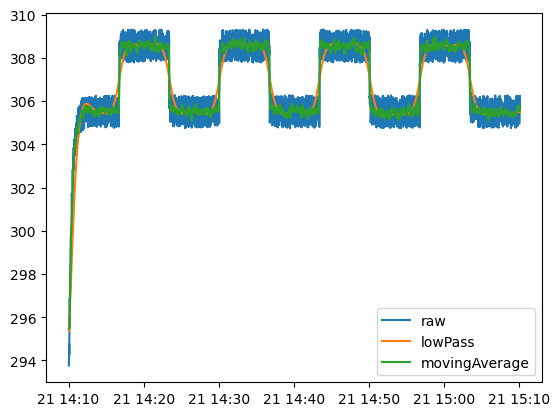

In [5]:
tsd.low_pass_filter(crit_freq=0.01, filter_order=2, variable="measured_T", tag="raw", new_tag="lowPass")
tsd.moving_average(window=10, variable="measured_T", tag="raw", new_tag="movingAverage")
# Plot the values
plt.plot(tsd["measured_T"])
plt.legend(tsd["measured_T"].columns.values)
plt.show()

An alternative is to call the preprocessing module. Let's check the current state of the DataFrame first and then use the preprocessing module:

In [6]:
tsd

Variables            measured_T                          
Tags                        raw     lowPass movingAverage
Time                                                     
2019-12-21 14:10:03  293.764306  295.362644    295.485683
2019-12-21 14:10:04  294.581815  295.508527    295.485683
2019-12-21 14:10:05  294.757593  295.655329    295.485683
2019-12-21 14:10:06  294.236406  295.802966    295.485683
2019-12-21 14:10:07  294.995937  295.951354    295.485683
...                         ...         ...           ...
2019-12-21 15:10:00  305.029739  305.493348    305.582428
2019-12-21 15:10:01  306.215838  305.493561    305.582428
2019-12-21 15:10:02  305.805173  305.493745    305.582428
2019-12-21 15:10:03  306.255180  305.493902    305.582428
2019-12-21 15:10:03  305.630872  305.494034    305.582428

[3610 rows x 3 columns]

In [7]:
from ebcpy import preprocessing
# Extract the column of interest to get the trajectory or array for processing
trajectory = tsd.get_columns_by_tag("raw", variables=["measured_T"], return_type="numpy")
print(trajectory)

[[293.76430587]
 [294.58181461]
 [294.75759264]
 ...
 [305.80517346]
 [306.25517972]
 [305.63087246]]


Now, we can apply either a filter or a moving-average. To further understand differences between both options, adjust the parameters in the box below and rerun the cell. You will see how the output changes. It's up to you, which function you use for your data, a general appraisal cannot be made.

**Note**: The syntax to get values for an existing variable with a new tag, you have to call:
```python
tsd.loc[:, (VARIABLE_NAME, NEW_TAG_NAME)] = VALUES
```
In this case: 

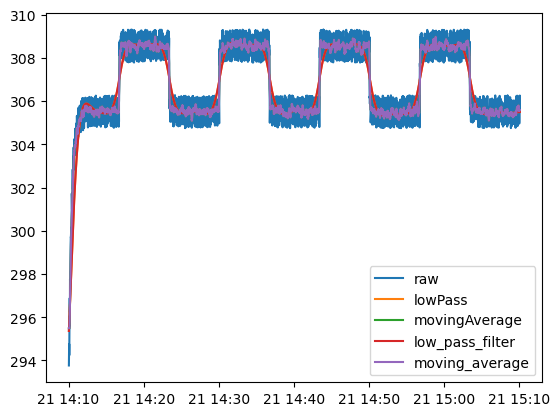

In [8]:
tsd.loc[:, ("measured_T", "low_pass_filter")] = preprocessing.low_pass_filter(
    data=trajectory, 
    crit_freq=0.01, 
    filter_order=2)
tsd.loc[:, ("measured_T", "moving_average")] = preprocessing.moving_average(
    data=trajectory, 
    window=10)
# Plot the values
plt.plot(tsd["measured_T"])
plt.legend(tsd["measured_T"].columns.values)
plt.show()

Now, let's assume we want to know when to turn on a certain device based on our measurements. Looking at our data, we know some device turned on or off if the temperature rises above some 34 °C. To reproduce the signal for our simulation, we can use the `create_on_off_signal` method. For this example we use the default tag "raw", however you may also try "moving_average" or other created tags.

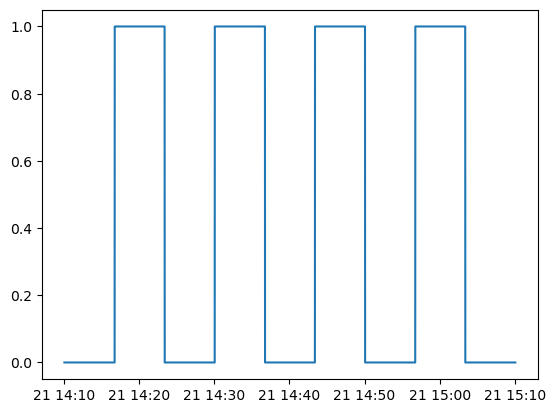

In [9]:
plt.close()
tsd = preprocessing.create_on_off_signal(df=tsd,
                                         col_names=["measured_T"],
                                         threshold= 307,
                                         col_names_new=["Device_Input"],
                                         tags=["raw"],
                                         new_tag="converted_signal")
plt.plot(tsd["Device_Input"])
plt.show()

If we are satisfied with our results, we may want to save our process in a file. For this case, the `TimeSeriesData`-Class holds a `save`-function:

In [10]:
save_path = os.path.join(os.getcwd(), "data", "measuredData_preprocessed.csv")
tsd.save(save_path, key="test")

Let's re-load the data and check if everything was saved correctly and the load-function works.

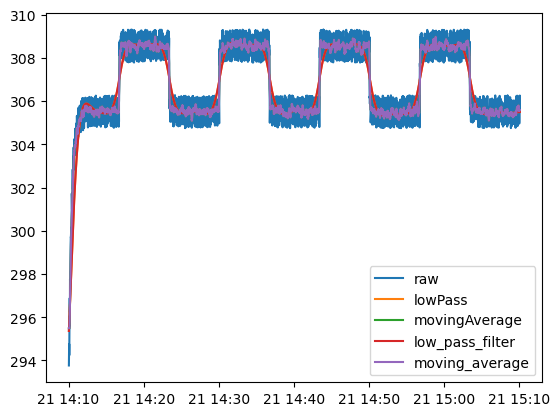

In [11]:
plt.close()
tsd = data_types.TimeSeriesData(save_path, key="test")
plt.plot(tsd["measured_T"])
plt.legend(tsd["measured_T"].columns.values)
plt.show()

Let's get a closer look at the DataFrame-Object.

We have two variables, the measured temperature and the created signal. Furthermore, we created new tags, allowing us to always recap where our data came from.

In [13]:
tsd

Variables            measured_T                                            \
Tags                        raw     lowPass movingAverage low_pass_filter   
Time                                                                        
2019-12-21 14:10:03  293.764306  295.362644    295.485683      295.362644   
2019-12-21 14:10:04  294.581815  295.508527    295.485683      295.508527   
2019-12-21 14:10:05  294.757593  295.655329    295.485683      295.655329   
2019-12-21 14:10:06  294.236406  295.802966    295.485683      295.802966   
2019-12-21 14:10:07  294.995937  295.951354    295.485683      295.951354   
...                         ...         ...           ...             ...   
2019-12-21 15:10:00  305.029739  305.493348    305.582428      305.493348   
2019-12-21 15:10:01  306.215838  305.493561    305.582428      305.493561   
2019-12-21 15:10:02  305.805173  305.493745    305.582428      305.493745   
2019-12-21 15:10:03  306.255180  305.493902    305.582428      305.493902   
2019-12-21 15:10:03  305.630872  305.494034    305.582428      305.494034   

Variables                              Device_Input  
Tags                moving_average converted_signal  
Time                                                 
2019-12-21 14:10:03     295.485683              0.0  
2019-12-21 14:10:04     295.485683              0.0  
2019-12-21 14:10:05     295.485683              0.0  
2019-12-21 14:10:06     295.485683              0.0  
2019-12-21 14:10:07     295.485683              0.0  
...                            ...              ...  
2019-12-21 15:10:00     305.582428              0.0  
2019-12-21 15:10:01     305.582428              0.0  
2019-12-21 15:10:02     305.582428              0.0  
2019-12-21 15:10:03     305.582428              0.0  
2019-12-21 15:10:03     305.582428              0.0  

[3610 rows x 6 columns]

As you may have noticed, the measurement was made for 1 hour with a 1 second interval. Let's assume you want to run the simulation with a bigger time-interval. To not only use the data, but also compare results at a later stage, the `preprocessing` module holds a function for you.
`clean_and_space_equally_time_series` takes your data and resamples it to the desired frequency. Try different inputs, like "1s", "30s", "2min", "1h" or others.

- Be aware that **upsampling** your data will create artificial values to fill the gaps. In contrast, **downsampling** is a valid and secure method.
- See [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases) for allowed frequencies like "15min".

In [15]:
tsd.clean_and_space_equally(desired_freq="1min")
tsd

d:\04_Python\Anaconda\envs\Dymola2FIWARE\lib\site-packages\ebcpy\preprocessing.py:317: UserWarning: You are upsampling your data. This may be dangerous. Carefully check the result to see if you introduced errors to the data.
  warnings.warn("You are upsampling your data. This may be dangerous. "
d:\04_Python\Anaconda\envs\Dymola2FIWARE\lib\site-packages\ebcpy\preprocessing.py:340: FutureWarning: first is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  delta_time = df.index[0] - df.resample(rule=desired_freq).first().first(desired_freq).index[0]


Variables               Device_Input  measured_T                  \
Tags                converted_signal     lowPass low_pass_filter   
2019-12-21 14:10:03              0.0  295.362644      295.362644   
2019-12-21 14:11:03              0.0  302.967651      302.967651   
2019-12-21 14:12:03              0.0  305.761296      305.761296   
2019-12-21 14:13:03              0.0  305.730389      305.730389   
2019-12-21 14:14:03              0.0  305.487325      305.487325   
...                              ...         ...             ...   
2019-12-21 15:06:03              0.0  305.410694      305.410694   
2019-12-21 15:07:03              0.0  305.469788      305.469788   
2019-12-21 15:08:03              0.0  305.472332      305.472332   
2019-12-21 15:09:03              0.0  305.447115      305.447115   
2019-12-21 15:10:03              0.0  305.493348      305.493348   

Variables                                                     
Tags                movingAverage moving_average         raw  
2019-12-21 14:10:03    295.485683     295.485683  293.764306  
2019-12-21 14:11:03    304.168432     304.168432  304.571352  
2019-12-21 14:12:03    305.299445     305.299445  304.772792  
2019-12-21 14:13:03    305.544055     305.544055  304.867753  
2019-12-21 14:14:03    305.462056     305.462056  304.970765  
...                           ...            ...         ...  
2019-12-21 15:06:03    305.272184     305.272184  304.991349  
2019-12-21 15:07:03    305.551311     305.551311  306.015593  
2019-12-21 15:08:03    305.409083     305.409083  305.844088  
2019-12-21 15:09:03    305.416989     305.416989  305.471418  
2019-12-21 15:10:03    305.582428     305.582428  305.029739  

[61 rows x 6 columns]

# Conversion

Now, let's get to the simulation part. If you are familiar with **Modelica**, you know *inputs from files* may either be in `.txt` or `.mat` format. Both options are supported in `ebcpy`.

Let's take our preprocessed data and convert it to first to .txt, then to .mat:

In [20]:
from ebcpy.utils import conversion
from ebcpy import TimeSeriesData

file_path = os.path.join(os.getcwd(), "data", "measuredData_preprocessed.csv")

tsd = TimeSeriesData(file_path, key="test")

save_path_txt = conversion.convert_tsd_to_modelica_txt(
    tsd=tsd,
    save_path_file=os.path.join(os.getcwd(), "data", "measuredData_preprocessed.txt"),
    table_name="Simulation_Input",
    # = [], = [("measured_T", "moving_average")] o.s. is also possible.
    columns=["Device_Input"],
    # Rerun the cell and change values 
    # below to understand these args.
    offset=0, 
    sep="\t")

# Let's print the first 15 lines to understand the result. 
# Simulation_Input is the table_name. 
# The tag is added to the varialbe
print("".join(open(save_path_txt, "r").readlines()[:15]))

#1
double Simulation_Input(3610, 2)
#time_in_s	Device_Input_converted_signal
0.0	0.0
1.0	0.0
2.0	0.0
3.0	0.0
4.0	0.0
5.0	0.0
6.0	0.0
7.0	0.0
8.0	0.0
9.0	0.0
10.0	0.0
11.0	0.0



In [21]:
conversion.convert_tsd_to_modelica_mat(
    tsd=tsd,
    save_path_file=os.path.join(os.getcwd(), "data", "measuredData_preprocessed.mat"),
    columns=[("measured_T", "moving_average")],
    offset=0)

'd:\\02_Git\\ebcpy\\tutorial\\data\\measuredData_preprocessed.mat'

# Dymola API

Now, we will run a simulation using the `DymolaAPI`-Class. Make sure you have **Dymola** with a valid **license** installed on your machine to get this to run.

If you are new to the research at the EBC-Institute, the [**AixLib**](https://github.com/RWTH-EBC/AixLib) is a good  starting point for modelling. Most systems in the area of building energy systems have already been implemented.

In [22]:
from ebcpy.simulationapi import dymola_api
test_package = os.path.join(os.getcwd(), "Modelica", "TestModel.mo")

DYM_API = dymola_api.DymolaAPI(
    # Used for saving simulation files etc.
    working_directory=os.path.join(os.getcwd(), "data"),
    # Name of the model you want to simulate
    model_name="Modelica.Thermal.FluidHeatFlow.Examples.PumpAndValve",
    # All package.mo files required.
    # For this MSL model, no further packages are required.
    packages=[],
    # Whether the Dymola Window should be visible or not
    show_window=True,
    # Set the output as equidistant (Events are not stored)
    equidistant_output=True,
    # In some cases MemoryExceptions may occur after some 1000 simulations.
    # Restart dymola to free up space.
    n_restart=100
)

13.03.2025-11:08:49 INFO DymolaAPI: -------------------------Initializing class DymolaAPI-------------------------
13.03.2025-11:08:49 INFO DymolaAPI: Using dymola installation at C:\Program Files\Dymola 2023x
13.03.2025-11:08:49 INFO DymolaAPI: Using dymola.exe: C:\Program Files\Dymola 2023x\bin64\Dymola.exe
13.03.2025-11:08:49 INFO DymolaAPI: Using dymola interface: C:\Program Files\Dymola 2023x\Modelica\Library\python_interface\dymola.egg
13.03.2025-11:08:49 INFO DymolaAPI: Open blank placeholder Dymola instance to ensure a licence during Dymola restarts
13.03.2025-11:08:58 INFO DymolaAPI: Loaded modules
13.03.2025-11:08:58 INFO DymolaAPI: Translating model 'Modelica.Thermal.FluidHeatFlow.Examples.PumpAndValve' to extract model variables 


**Note:** If you have Dymola installed in an unusual path (e.g. on Windows outside of `C:\Program Files` (and for 64bit-systems `C:\Program Files (x86)`)) you have to provide the path of your dymola interface and the dymola-executable. Add the following kwargs to the code above to do so:

```python
dymola_api.DymolaAPI(
     # Usual arguments go here...
     dymola_path=r"PATH_TO_DYMOLA\Dymola 20XX")
```


Let's run a simulation for one minute (60 s) and look at the output:

In [23]:
sim_setup = {"start_time": 0,
             "stop_time": 60}
# This simulation setup is equal to the simulation-setup window in Dymola.
# Look at the documentation to see what other parameters you may set.
DYM_API.set_sim_setup(sim_setup)
DYM_API.result_names = ["ambient1.flowPort.m_flow"]
# Simulate the model. Note that there are different options at hand to get the simulation results. 
# See the docstring of the class for more information on that.
# We will use matfiles for now:
df = DYM_API.simulate()
print(df)

13.03.2025-11:09:53 INFO DymolaAPI: Finished 1 simulations on 1 processes in 0:00:00


Variables ambient1.flowPort.m_flow
Tags                           sim
Time                              
0.0                      -0.160850
1.0                      -0.954451
2.0                      -0.954451
3.0                      -0.954451
4.0                      -0.954451
...                            ...
56.0                     -0.954451
57.0                     -0.954451
58.0                     -0.954451
59.0                     -0.954451
60.0                     -0.954451

[61 rows x 1 columns]


You may have noticed that our simulation is not equal to our measurement. 

To minimize the error between simulation and measurement, the EBC institute offers the python framework `AixCaliBuHa`. `AixCaliBuHa` offers different calibrators, all based on the `Optimizer` in `ebcpy`. The underlying data-structure is the `data_types` module.  
You can find **`AixCaliBuHa`** [here](https://github.com/RWTH-EBC/ebcpy/AixCaliBuHA)

# Optimization

As mentioned above, `ebcpy` provides an `Optimizer`. Currently, we use the optimizer primarily for calibration. However, the optimizer is capable of solving other problems as well.

We offer an easy to use API for some open-source solvers (`scipy`, `dlib`) as well as own implementation of existings methods (currenlty in development). 

**Note:** If you have a reoccuring task of optimization with a similar objective function, the use of this framework may make sense for you. If you just optimize once, this won't be much of a help. 

Let's assume we have some function and we want to approximate a quadratic formula to it.

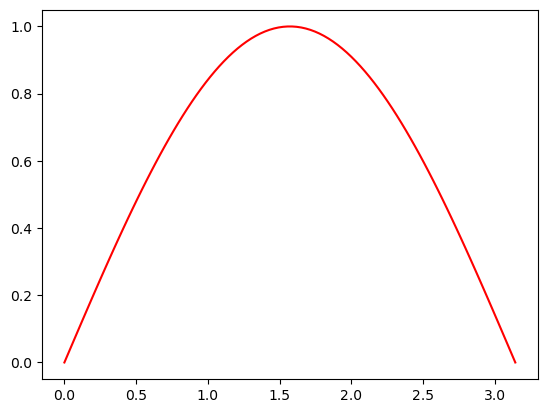

In [24]:
import numpy as np
# Generate array between 0 and pi
data = np.linspace(0, np.pi, 100)
goal = np.sin(data)
plt.plot(data, goal, "r")
plt.show()

Let's find the optimal parameters by creating our own Optimizer. You may want to pass own arguments to the class for usage in the objective. Just overwrite the `__init__` of the `Optimizer`. 
Depending on your use-case, you may want to pass `x0` and `bounds` as well. Some solvers don't require initial values. Boundaries are mostly required.

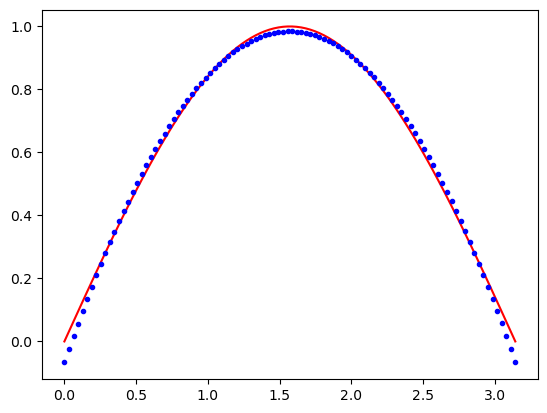

In [25]:
from ebcpy.optimization import Optimizer

class MyCustomOptimizer(Optimizer):

    def __init__(self, goal, data, **kwargs):
        super().__init__(**kwargs)
        self.goal = goal
        self.data = data

    def obj(self, xk, *args):
        # Calculate the quadratic formula:
        quadratic_func = xk[0] * self.data ** 2\
                            + xk[1] * self.data\
                            + xk[2]
        # Return the MAE of the quadratic function.
        return np.sum(np.abs(self.goal - quadratic_func))

mco = MyCustomOptimizer(goal=goal,
                        data=data,
                        bounds = [(-100, 100), (-100, 100), (-100, 100)]  # Specify bounds to the optimization
                        )

res = mco.optimize(framework="scipy_differential_evolution", method="best1bin")
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

In order to see the advantage of the optimizer class, see the solutions for different frameworks below.

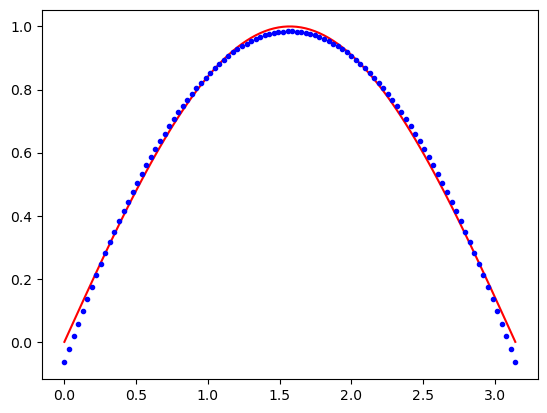

In [28]:
res = mco.optimize(framework="scipy_minimize",
                   method="L-BFGS-B",
                   x0=[0, 0, 0]  # L-BFGS-B method requires an initial guess.
                  )
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

**Note:** In order to use the framework dlib_minimize, you might need to install dlib first.

In [31]:
res = mco.optimize(framework="dlib_minimize",
                   num_function_calls=1000  # Limit number of function calls
                   )
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

ImportError: Please install dlib to use the minimize_dlib function.

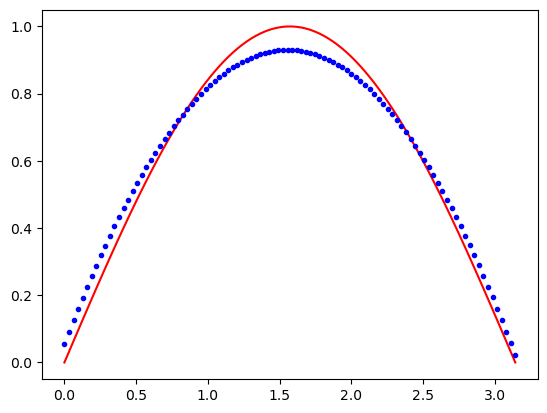

In [32]:
res = mco.optimize(framework="pymoo", method="DE")
plt.plot(data, goal, "r")
plt.plot(data, res.x[0] * data ** 2 + res.x[1] * data + res.x[2], "b.")
plt.show()

**If you have any questions or encounter bugs, please feel free to [raise an issue](https://github.com/RWTH-EBC/ebcpy/issues)! We hope this tutorial made the use case and usage of `ebcpy` clear to you. We also refer to the python examples in the examples folder. Here you can also test the objects within in the framework.**